In [23]:
# ---- Uncomment the following to run in colab, re-run this cell after installation -----
# try:
#   import decodanda
# except ImportError:
#   !pip install decodanda
#   print('\n\nInstalled Decodanda. Stopping RUNTIME. Colaboratory will restart automatically. Please run again.\n\n')
#   exit()

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
np.random.seed(1123)
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.facecolor'] = 'w'
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from decodanda import Decodanda, generate_synthetic_data, pltcolors


### Disentangling correlated behavioral variables to avoid confounds
Say we are running an experiment where a subject has to learn a stimulus-action association: when stimulus A pops out on the screen, the subject has to move a lever to the right, when B is presented, the subject needs to move the lever to the left.

In this thought experiment we record from the subject's retina, which we assume only responds to the stimulus, and not to the action.

After training, the subject performs the task with ~ 80% accuracy. Let's create a data set with these three ingredients:
- two variables (```stimulus```, ```action```)
- a 80% correlation between the labels
- a recorded activity raster that only responds to ```stimulus```

In the plot below, pay attention to how correlated the two behavioral variables are

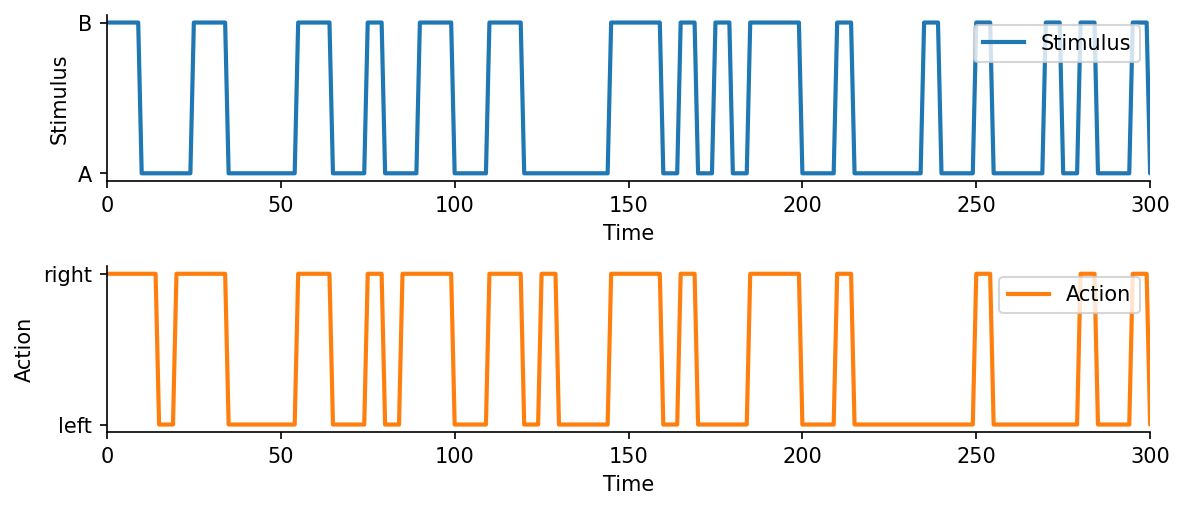

In [30]:
data = generate_synthetic_data(n_neurons=60, n_trials=150, rateB=0, rateA=0.2, keyA='stimulus', keyB='action', corrAB=0.8)
#                                                             ^ no response to action                         ^ 80% correlation


f, axs = plt.subplots(2, 1, figsize=(8, 3.5))
sns.despine(f)

axs[0].plot(data['stimulus'], linewidth=2, label='Stimulus')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Stimulus')
axs[0].set_yticks([-1, 1])
axs[0].set_yticklabels(['A', 'B'])
axs[0].set_xlim([0, 300])
_= axs[0].legend()

axs[1].plot(data['action'], linewidth=2, label='Action', color=pltcolors[1])
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Action')
axs[1].set_yticks([-1, 1])
axs[1].set_yticklabels(['left', 'right'])
axs[1].set_xlim([0, 300])
_= axs[1].legend()



If we decode the ```stimulus``` variable from neural activity, we find a very good performance, as we expect.

However we also find a __significant performance__ when we decode ```action```, even if the activity does not respond to action at all!

This is caused by the Action and Stimulus variable to be correlated, acting as a confound for each other.

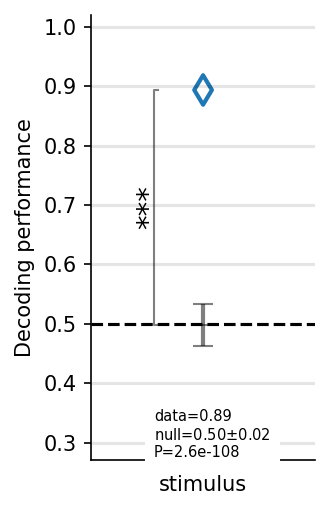

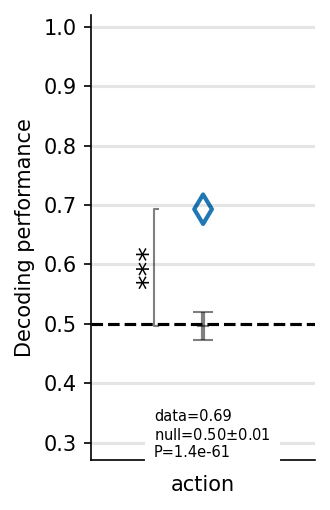

In [28]:
# Creating the decodanda object for the Stimulus variable

stimulus_dec = Decodanda(
    data=data,
    conditions={'stimulus': [-1, 1]},
)

# Creating the decodanda object for the Action variable

action_dec = Decodanda(
    data=data,
    conditions={'action': [-1, 1]},
)

# Decoding the two variables

decoding_params = {
    'training_fraction': 0.7,       # fraction of trials used for training during cross validation
    'cross_validations': 20,        # number of different training-testing separations
    'nshuffles': 25,                # number of null model repetitions to compute significance
    'plot': True,                   # this generates a recap plot with performance, null model bars, and significance
    'ndata': 100                    # number of population vector samples per class during cross validation
}

res, null = stimulus_dec.decode(**decoding_params)
res, null = action_dec.decode(**decoding_params)

This problem can be solved by specifying two conditions in a single ```Decodanda``` object. This ensures that  all variables are properly balanced during decoding of each single variable, effectively breaking the confounding correlation between the two variables.

When calling the ```decode()``` function, ```Decodanda``` will decode both variables in this balanced way. As a result, Stimulus will be decodable, while Action will not, as it should be per construction of the data set.

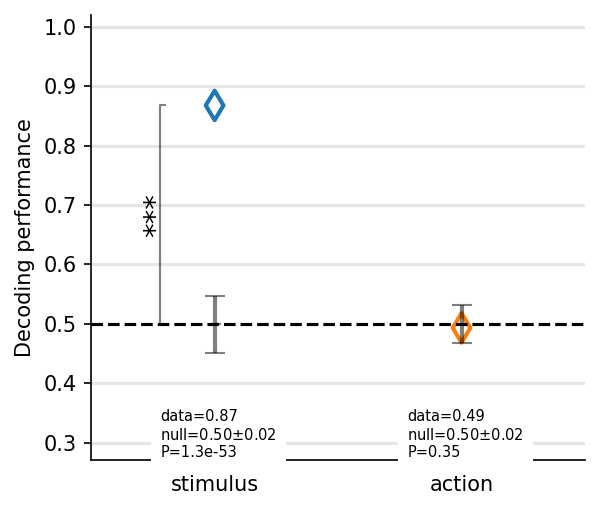

In [29]:
# Creating the decodanda object for the Action variable

dec = Decodanda(
    data=data,
    conditions={
        'stimulus': [-1, 1],
        'action': [-1, 1]
    },
)

res, null = dec.decode(**decoding_params)